In [1]:
import os
from pathlib import Path
import random

import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread_collection, imshow_collection, imsave
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

from IPython import display

%matplotlib inline

In [2]:
def get_portable_path() -> Path:
    """Utility for getting a sensible working directory whether running as a script or in Colab"""
    try:
        outdir = Path(__file__).resolve().parent
        return outdir
    except NameError:
        print("Possible use of Colab detected. Attempting to exploit `globals()`...")
    try:
        outdir = Path(globals()["_dh"][0]).resolve()
        return outdir
    except KeyError:
        print("Colab not detected.")
        print("Defaulting to current working directory for files.")
        return Path().resolve()

In [3]:
OUTDIR = get_portable_path() / "outputs"
DATADIR = get_portable_path() / "dataset"
BATCH_SIZE = 16
MAX_GEN = 1000
IMAGE_SHAPE = (256, 256)
POP_SIZE = 4
population = []

Possible use of Colab detected. Attempting to exploit `globals()`...
Possible use of Colab detected. Attempting to exploit `globals()`...


In [4]:
def init_population():
    global population
    population = []
    #creating a collection with the available images
    images = imread_collection(str(DATADIR / "train" / "*.jpg"))
    for img in images[: POP_SIZE]:
        population.append(resize(img, IMAGE_SHAPE, anti_aliasing=True))

In [5]:
# # mutation
# The images have range of values from 0 10 1

def display_images():
    fig, axes = plt.subplots(nrows=2, ncols=2)

    ax = axes.ravel()

    ax[0].imshow(population[0])
    ax[0].set_title("1")

    ax[1].imshow(population[1])
    ax[1].set_title("2")

    ax[2].imshow(population[2])
    ax[2].set_title("2")

    ax[3].imshow(population[3])
    ax[3].set_title("3")

    plt.tight_layout()
    display.clear_output(wait=True)
    plt.show()
    plt.pause(1)

In [6]:
def mutate(gene):
    """Gene is a (IMAGE_SIZE) * 3 channel input image.
    Here mutate is swapping the values within the image between channels
    """
    x = random.randint(0, IMAGE_SHAPE[0] - 1)
    y = random.randint(x, IMAGE_SHAPE[1] - 1)
    ch1 = random.randint(0, 2)
    ch2 = random.randint(0, 2)
    # get the square
    gene[x:y, x:y, ch1], gene[x:y, x:y, ch2] = gene[x:y, x:y, ch2], gene[x:y, x:y, ch1]
    return gene


In [7]:
def crossover(gene1, gene2):
    """Gene is a (IMAGE_SIZE) * 3 channel input image.
    Here crossover is swapping the values of one channel between images
    """
    x = random.randint(0, IMAGE_SHAPE[0] - 1)
    y = random.randint(x, IMAGE_SHAPE[1] - 1)
    ch1 = random.randint(0, 2)
    ch2 = random.randint(0, 2)
    # get the square
    gene1[x:y, x:y, ch1], gene1[x:y, x:y, ch2] = gene2[x:y, x:y, ch2], gene2[x:y, x:y, ch1]
    return gene1

In [9]:
# Initialize the population
init_population()

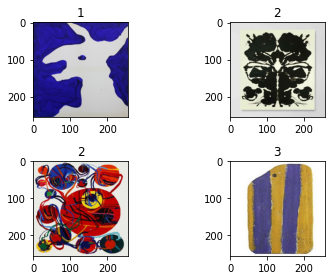

In [10]:
display_images()

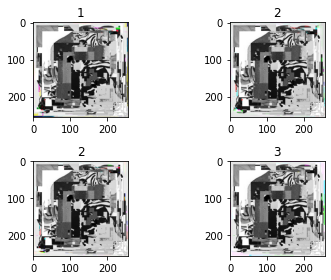

In [11]:
for gen in range(MAX_GEN):
    for gene in population:
        # Mutation
        gene = mutate(gene)
        # crossover 
        gene = crossover(gene, population[random.randint(0, POP_SIZE-1)])
    if gen % 100 == 0:
        display_images()

In [27]:
a = resize(population[0], (1080,1080), anti_aliasing=True)

In [33]:
imsave(OUTDIR/"test.png", a)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
